<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


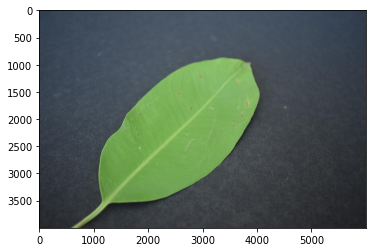

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

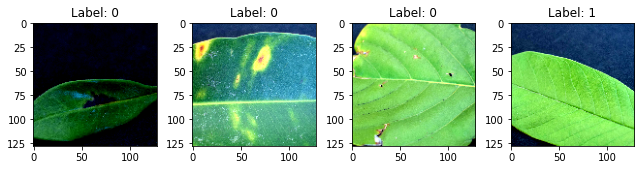

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:21] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:23] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2580734589360947 samples/sec                   batch loss = 2.8640363216400146 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.259862500510637 samples/sec                   batch loss = 0.7870153188705444 | accuracy = 0.4


Epoch[1] Batch[15] Speed: 1.2711753246202206 samples/sec                   batch loss = 1.452706217765808 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.273710935643541 samples/sec                   batch loss = 0.6331663131713867 | accuracy = 0.45


Epoch[1] Batch[25] Speed: 1.2728633533497375 samples/sec                   batch loss = 0.748043417930603 | accuracy = 0.48


Epoch[1] Batch[30] Speed: 1.2696090665432465 samples/sec                   batch loss = 0.900335431098938 | accuracy = 0.49166666666666664


Epoch[1] Batch[35] Speed: 1.2698743910044066 samples/sec                   batch loss = 0.5033901333808899 | accuracy = 0.5142857142857142


Epoch[1] Batch[40] Speed: 1.2713614311933836 samples/sec                   batch loss = 0.4987335801124573 | accuracy = 0.53125


Epoch[1] Batch[45] Speed: 1.2726697593071643 samples/sec                   batch loss = 0.5870147943496704 | accuracy = 0.5333333333333333


Epoch[1] Batch[50] Speed: 1.2771310541718266 samples/sec                   batch loss = 1.377275824546814 | accuracy = 0.545


Epoch[1] Batch[55] Speed: 1.2693789074115127 samples/sec                   batch loss = 0.37348780035972595 | accuracy = 0.5636363636363636


Epoch[1] Batch[60] Speed: 1.2661141075836746 samples/sec                   batch loss = 0.2723767161369324 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2662539110945268 samples/sec                   batch loss = 0.5988889336585999 | accuracy = 0.5846153846153846


Epoch[1] Batch[70] Speed: 1.2705887520604107 samples/sec                   batch loss = 0.5121045708656311 | accuracy = 0.5857142857142857


Epoch[1] Batch[75] Speed: 1.269029121638472 samples/sec                   batch loss = 0.6361648440361023 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.2653387254657584 samples/sec                   batch loss = 0.4385784864425659 | accuracy = 0.575


Epoch[1] Batch[85] Speed: 1.2660929916236843 samples/sec                   batch loss = 0.365086168050766 | accuracy = 0.5794117647058824


Epoch[1] Batch[90] Speed: 1.2638592583485806 samples/sec                   batch loss = 0.6741818785667419 | accuracy = 0.5888888888888889


Epoch[1] Batch[95] Speed: 1.2714693440160545 samples/sec                   batch loss = 0.3733712434768677 | accuracy = 0.5921052631578947


Epoch[1] Batch[100] Speed: 1.2676546997483236 samples/sec                   batch loss = 0.5812228918075562 | accuracy = 0.585


Epoch[1] Batch[105] Speed: 1.2680455133065593 samples/sec                   batch loss = 0.5689221620559692 | accuracy = 0.5904761904761905


Epoch[1] Batch[110] Speed: 1.2584378080046326 samples/sec                   batch loss = 0.5492619872093201 | accuracy = 0.5931818181818181


Epoch[1] Batch[115] Speed: 1.2664476611782438 samples/sec                   batch loss = 0.5883551239967346 | accuracy = 0.5956521739130435


Epoch[1] Batch[120] Speed: 1.2694807204401395 samples/sec                   batch loss = 0.7222422361373901 | accuracy = 0.6


Epoch[1] Batch[125] Speed: 1.277900032897295 samples/sec                   batch loss = 0.5244610905647278 | accuracy = 0.6


Epoch[1] Batch[130] Speed: 1.275076627493481 samples/sec                   batch loss = 1.039502501487732 | accuracy = 0.5980769230769231


Epoch[1] Batch[135] Speed: 1.2670552947683835 samples/sec                   batch loss = 0.5120506286621094 | accuracy = 0.5907407407407408


Epoch[1] Batch[140] Speed: 1.260476046154602 samples/sec                   batch loss = 0.5339952707290649 | accuracy = 0.5964285714285714


Epoch[1] Batch[145] Speed: 1.2783778396431773 samples/sec                   batch loss = 0.7857034206390381 | accuracy = 0.6


Epoch[1] Batch[150] Speed: 1.2674257273307317 samples/sec                   batch loss = 0.37796226143836975 | accuracy = 0.6083333333333333


Epoch[1] Batch[155] Speed: 1.2751040526080624 samples/sec                   batch loss = 0.4265809655189514 | accuracy = 0.6064516129032258


Epoch[1] Batch[160] Speed: 1.269204518512657 samples/sec                   batch loss = 0.3711727559566498 | accuracy = 0.6109375


Epoch[1] Batch[165] Speed: 1.2679788117172823 samples/sec                   batch loss = 0.4881895184516907 | accuracy = 0.6121212121212121


Epoch[1] Batch[170] Speed: 1.2706463937418688 samples/sec                   batch loss = 0.9193109273910522 | accuracy = 0.6088235294117647


Epoch[1] Batch[175] Speed: 1.2672712105249004 samples/sec                   batch loss = 0.7986974716186523 | accuracy = 0.61


Epoch[1] Batch[180] Speed: 1.2672983966241667 samples/sec                   batch loss = 0.42565983533859253 | accuracy = 0.6097222222222223


Epoch[1] Batch[185] Speed: 1.2666890953644472 samples/sec                   batch loss = 0.4690764248371124 | accuracy = 0.6108108108108108


Epoch[1] Batch[190] Speed: 1.2669357879416783 samples/sec                   batch loss = 0.6837084889411926 | accuracy = 0.6131578947368421


Epoch[1] Batch[195] Speed: 1.2685863810608398 samples/sec                   batch loss = 0.6673043966293335 | accuracy = 0.6128205128205129


Epoch[1] Batch[200] Speed: 1.2715999237519786 samples/sec                   batch loss = 2.2200918197631836 | accuracy = 0.615


Epoch[1] Batch[205] Speed: 1.2658898939720513 samples/sec                   batch loss = 0.6447538137435913 | accuracy = 0.6146341463414634


Epoch[1] Batch[210] Speed: 1.2604498148416525 samples/sec                   batch loss = 0.4685421884059906 | accuracy = 0.6202380952380953


Epoch[1] Batch[215] Speed: 1.2625502554680395 samples/sec                   batch loss = 0.7070320844650269 | accuracy = 0.622093023255814


Epoch[1] Batch[220] Speed: 1.2677804734547855 samples/sec                   batch loss = 0.8698556423187256 | accuracy = 0.625


Epoch[1] Batch[225] Speed: 1.2790634786830961 samples/sec                   batch loss = 0.751929521560669 | accuracy = 0.63


Epoch[1] Batch[230] Speed: 1.2702384916450924 samples/sec                   batch loss = 0.4304696321487427 | accuracy = 0.6315217391304347


Epoch[1] Batch[235] Speed: 1.2701925228816442 samples/sec                   batch loss = 0.8259523510932922 | accuracy = 0.6319148936170212


Epoch[1] Batch[240] Speed: 1.2657513167544705 samples/sec                   batch loss = 0.43817242980003357 | accuracy = 0.6354166666666666


Epoch[1] Batch[245] Speed: 1.2656497191081377 samples/sec                   batch loss = 0.27618053555488586 | accuracy = 0.6346938775510204


Epoch[1] Batch[250] Speed: 1.2707539927080853 samples/sec                   batch loss = 0.5740523338317871 | accuracy = 0.633


Epoch[1] Batch[255] Speed: 1.2752819083937204 samples/sec                   batch loss = 0.25599169731140137 | accuracy = 0.6333333333333333


Epoch[1] Batch[260] Speed: 1.2691742742133085 samples/sec                   batch loss = 0.6863520741462708 | accuracy = 0.6317307692307692


Epoch[1] Batch[265] Speed: 1.2635615150793962 samples/sec                   batch loss = 0.40428104996681213 | accuracy = 0.6320754716981132


Epoch[1] Batch[270] Speed: 1.2647805041913927 samples/sec                   batch loss = 0.8457666039466858 | accuracy = 0.6305555555555555


Epoch[1] Batch[275] Speed: 1.2670115654758332 samples/sec                   batch loss = 0.4723851680755615 | accuracy = 0.6327272727272727


Epoch[1] Batch[280] Speed: 1.2698197987160582 samples/sec                   batch loss = 0.6945372223854065 | accuracy = 0.6330357142857143


Epoch[1] Batch[285] Speed: 1.2767353983401968 samples/sec                   batch loss = 0.7979756593704224 | accuracy = 0.6342105263157894


Epoch[1] Batch[290] Speed: 1.263631654872195 samples/sec                   batch loss = 0.9423855543136597 | accuracy = 0.6336206896551724


Epoch[1] Batch[295] Speed: 1.2622947255087917 samples/sec                   batch loss = 0.6073657870292664 | accuracy = 0.6338983050847458


Epoch[1] Batch[300] Speed: 1.2715001796159402 samples/sec                   batch loss = 0.8843342065811157 | accuracy = 0.6333333333333333


Epoch[1] Batch[305] Speed: 1.2778287868566829 samples/sec                   batch loss = 0.507859468460083 | accuracy = 0.6336065573770492


Epoch[1] Batch[310] Speed: 1.2735643568715644 samples/sec                   batch loss = 0.6981377601623535 | accuracy = 0.6346774193548387


Epoch[1] Batch[315] Speed: 1.2650731941401254 samples/sec                   batch loss = 0.8663703799247742 | accuracy = 0.6349206349206349


Epoch[1] Batch[320] Speed: 1.270059828381751 samples/sec                   batch loss = 0.5396466851234436 | accuracy = 0.6359375


Epoch[1] Batch[325] Speed: 1.2722128020556547 samples/sec                   batch loss = 0.6367611289024353 | accuracy = 0.6392307692307693


Epoch[1] Batch[330] Speed: 1.2763752353374507 samples/sec                   batch loss = 0.6234971880912781 | accuracy = 0.6386363636363637


Epoch[1] Batch[335] Speed: 1.2745641015745455 samples/sec                   batch loss = 0.7807406187057495 | accuracy = 0.6388059701492538


Epoch[1] Batch[340] Speed: 1.2737893633390116 samples/sec                   batch loss = 1.0919179916381836 | accuracy = 0.6397058823529411


Epoch[1] Batch[345] Speed: 1.2664890570171665 samples/sec                   batch loss = 0.21620100736618042 | accuracy = 0.6413043478260869


Epoch[1] Batch[350] Speed: 1.2799818361952566 samples/sec                   batch loss = 0.6801238059997559 | accuracy = 0.6421428571428571


Epoch[1] Batch[355] Speed: 1.2736653920560652 samples/sec                   batch loss = 0.3591240644454956 | accuracy = 0.6450704225352113


Epoch[1] Batch[360] Speed: 1.274390802020313 samples/sec                   batch loss = 0.8405999541282654 | accuracy = 0.6465277777777778


Epoch[1] Batch[365] Speed: 1.266497565965994 samples/sec                   batch loss = 0.48366421461105347 | accuracy = 0.6486301369863013


Epoch[1] Batch[370] Speed: 1.2737953594418665 samples/sec                   batch loss = 0.6569621562957764 | accuracy = 0.6486486486486487


Epoch[1] Batch[375] Speed: 1.2674923707415426 samples/sec                   batch loss = 0.595467746257782 | accuracy = 0.6473333333333333


Epoch[1] Batch[380] Speed: 1.2738975920099547 samples/sec                   batch loss = 1.3527088165283203 | accuracy = 0.6486842105263158


Epoch[1] Batch[385] Speed: 1.2764842923771047 samples/sec                   batch loss = 0.3332895338535309 | accuracy = 0.6506493506493507


Epoch[1] Batch[390] Speed: 1.2720483391858783 samples/sec                   batch loss = 0.7967767715454102 | accuracy = 0.65


Epoch[1] Batch[395] Speed: 1.2634427615158046 samples/sec                   batch loss = 0.4976111352443695 | accuracy = 0.6518987341772152


Epoch[1] Batch[400] Speed: 1.2622905466963616 samples/sec                   batch loss = 0.2448500394821167 | accuracy = 0.65125


Epoch[1] Batch[405] Speed: 1.2660365266115912 samples/sec                   batch loss = 0.4714496433734894 | accuracy = 0.6537037037037037


Epoch[1] Batch[410] Speed: 1.2755750182719567 samples/sec                   batch loss = 0.9808520674705505 | accuracy = 0.6530487804878049


Epoch[1] Batch[415] Speed: 1.2713906236584434 samples/sec                   batch loss = 0.8470656871795654 | accuracy = 0.653012048192771


Epoch[1] Batch[420] Speed: 1.2677104470856524 samples/sec                   batch loss = 0.6136261820793152 | accuracy = 0.6523809523809524


Epoch[1] Batch[425] Speed: 1.2664890570171665 samples/sec                   batch loss = 0.3737308382987976 | accuracy = 0.6535294117647059


Epoch[1] Batch[430] Speed: 1.27634086146916 samples/sec                   batch loss = 0.5558547377586365 | accuracy = 0.6546511627906977


Epoch[1] Batch[435] Speed: 1.278096097846188 samples/sec                   batch loss = 0.2886512875556946 | accuracy = 0.6551724137931034


Epoch[1] Batch[440] Speed: 1.27311545180447 samples/sec                   batch loss = 0.7268219590187073 | accuracy = 0.6539772727272727


Epoch[1] Batch[445] Speed: 1.2528813210995582 samples/sec                   batch loss = 0.46338361501693726 | accuracy = 0.6561797752808989


Epoch[1] Batch[450] Speed: 1.2705406411387994 samples/sec                   batch loss = 0.36023494601249695 | accuracy = 0.6577777777777778


Epoch[1] Batch[455] Speed: 1.2724907975609023 samples/sec                   batch loss = 0.7239216566085815 | accuracy = 0.6576923076923077


Epoch[1] Batch[460] Speed: 1.2756184677857831 samples/sec                   batch loss = 0.4326249361038208 | accuracy = 0.6592391304347827


Epoch[1] Batch[465] Speed: 1.2721960162131056 samples/sec                   batch loss = 0.42668867111206055 | accuracy = 0.6591397849462366


Epoch[1] Batch[470] Speed: 1.2641227562901107 samples/sec                   batch loss = 0.8216263055801392 | accuracy = 0.6595744680851063


Epoch[1] Batch[475] Speed: 1.2717392062363462 samples/sec                   batch loss = 0.15798288583755493 | accuracy = 0.6610526315789473


Epoch[1] Batch[480] Speed: 1.275366055828645 samples/sec                   batch loss = 1.0537264347076416 | accuracy = 0.6614583333333334


Epoch[1] Batch[485] Speed: 1.2716482113172125 samples/sec                   batch loss = 0.9064640998840332 | accuracy = 0.6597938144329897


Epoch[1] Batch[490] Speed: 1.2784030690422494 samples/sec                   batch loss = 0.7137576341629028 | accuracy = 0.6607142857142857


Epoch[1] Batch[495] Speed: 1.2683815238269625 samples/sec                   batch loss = 0.283780574798584 | accuracy = 0.6606060606060606


Epoch[1] Batch[500] Speed: 1.264898746449233 samples/sec                   batch loss = 0.5634258389472961 | accuracy = 0.6595


Epoch[1] Batch[505] Speed: 1.2685125250862002 samples/sec                   batch loss = 0.28237098455429077 | accuracy = 0.6608910891089109


Epoch[1] Batch[510] Speed: 1.2689916868764561 samples/sec                   batch loss = 0.9542315602302551 | accuracy = 0.6612745098039216


Epoch[1] Batch[515] Speed: 1.2731988304661621 samples/sec                   batch loss = 0.5251373648643494 | accuracy = 0.6606796116504854


Epoch[1] Batch[520] Speed: 1.2666970331796057 samples/sec                   batch loss = 0.24116124212741852 | accuracy = 0.6615384615384615


Epoch[1] Batch[525] Speed: 1.2651566675431731 samples/sec                   batch loss = 0.9060609340667725 | accuracy = 0.6614285714285715


Epoch[1] Batch[530] Speed: 1.271335419235208 samples/sec                   batch loss = 0.7902045249938965 | accuracy = 0.6613207547169812


Epoch[1] Batch[535] Speed: 1.2692564652604432 samples/sec                   batch loss = 1.146798849105835 | accuracy = 0.6602803738317757


Epoch[1] Batch[540] Speed: 1.269328103055677 samples/sec                   batch loss = 0.8670872449874878 | accuracy = 0.6606481481481481


Epoch[1] Batch[545] Speed: 1.2706057841998868 samples/sec                   batch loss = 0.24954941868782043 | accuracy = 0.6628440366972477


Epoch[1] Batch[550] Speed: 1.267585932296808 samples/sec                   batch loss = 0.2503790557384491 | accuracy = 0.6645454545454546


Epoch[1] Batch[555] Speed: 1.2661006353287714 samples/sec                   batch loss = 0.20164455473423004 | accuracy = 0.6648648648648648


Epoch[1] Batch[560] Speed: 1.2735363212406758 samples/sec                   batch loss = 0.7037403583526611 | accuracy = 0.6647321428571429


Epoch[1] Batch[565] Speed: 1.2755291473322496 samples/sec                   batch loss = 0.5110214948654175 | accuracy = 0.6650442477876106


Epoch[1] Batch[570] Speed: 1.2764626348658574 samples/sec                   batch loss = 0.38414543867111206 | accuracy = 0.6657894736842105


Epoch[1] Batch[575] Speed: 1.270107806743514 samples/sec                   batch loss = 0.6228094100952148 | accuracy = 0.6660869565217391


Epoch[1] Batch[580] Speed: 1.267678070887355 samples/sec                   batch loss = 0.3408486247062683 | accuracy = 0.6668103448275862


Epoch[1] Batch[585] Speed: 1.2688744055891168 samples/sec                   batch loss = 0.4487490653991699 | accuracy = 0.667094017094017


Epoch[1] Batch[590] Speed: 1.271979865720929 samples/sec                   batch loss = 1.7989999055862427 | accuracy = 0.6682203389830509


Epoch[1] Batch[595] Speed: 1.2662956765733637 samples/sec                   batch loss = 0.7575752139091492 | accuracy = 0.6684873949579831


Epoch[1] Batch[600] Speed: 1.2616616660577902 samples/sec                   batch loss = 0.9597712159156799 | accuracy = 0.6691666666666667


Epoch[1] Batch[605] Speed: 1.2660338515752323 samples/sec                   batch loss = 0.5685688853263855 | accuracy = 0.6706611570247933


Epoch[1] Batch[610] Speed: 1.268635399318967 samples/sec                   batch loss = 0.43115174770355225 | accuracy = 0.6709016393442623


Epoch[1] Batch[615] Speed: 1.2776744476853614 samples/sec                   batch loss = 0.3246711790561676 | accuracy = 0.6719512195121952


Epoch[1] Batch[620] Speed: 1.2788440136814805 samples/sec                   batch loss = 0.8482934236526489 | accuracy = 0.6737903225806452


Epoch[1] Batch[625] Speed: 1.2668498794291887 samples/sec                   batch loss = 0.7496012449264526 | accuracy = 0.6732


Epoch[1] Batch[630] Speed: 1.2679616582763003 samples/sec                   batch loss = 0.6499136686325073 | accuracy = 0.6738095238095239


Epoch[1] Batch[635] Speed: 1.2745232412326093 samples/sec                   batch loss = 0.4603814482688904 | accuracy = 0.6748031496062992


Epoch[1] Batch[640] Speed: 1.2718974180215923 samples/sec                   batch loss = 0.8886528611183167 | accuracy = 0.675


Epoch[1] Batch[645] Speed: 1.2712861921092766 samples/sec                   batch loss = 0.5337923765182495 | accuracy = 0.6751937984496124


Epoch[1] Batch[650] Speed: 1.2650911280679216 samples/sec                   batch loss = 1.3842277526855469 | accuracy = 0.6734615384615384


Epoch[1] Batch[655] Speed: 1.2689075147219209 samples/sec                   batch loss = 0.33234378695487976 | accuracy = 0.6751908396946565


Epoch[1] Batch[660] Speed: 1.2748736408051577 samples/sec                   batch loss = 0.4724043309688568 | accuracy = 0.6746212121212121


Epoch[1] Batch[665] Speed: 1.2725569129472902 samples/sec                   batch loss = 0.5524981021881104 | accuracy = 0.6740601503759398


Epoch[1] Batch[670] Speed: 1.2730029127619156 samples/sec                   batch loss = 0.7041028738021851 | accuracy = 0.6742537313432836


Epoch[1] Batch[675] Speed: 1.269975514472743 samples/sec                   batch loss = 0.6718489527702332 | accuracy = 0.6737037037037037


Epoch[1] Batch[680] Speed: 1.2685136760224363 samples/sec                   batch loss = 0.7481450438499451 | accuracy = 0.674264705882353


Epoch[1] Batch[685] Speed: 1.2667806253694602 samples/sec                   batch loss = 0.5067283511161804 | accuracy = 0.6740875912408759


Epoch[1] Batch[690] Speed: 1.2736134705379807 samples/sec                   batch loss = 0.4143412709236145 | accuracy = 0.6742753623188406


Epoch[1] Batch[695] Speed: 1.2744503381727943 samples/sec                   batch loss = 0.5902000069618225 | accuracy = 0.6744604316546763


Epoch[1] Batch[700] Speed: 1.2752730871282993 samples/sec                   batch loss = 0.3399216830730438 | accuracy = 0.6746428571428571


Epoch[1] Batch[705] Speed: 1.2625978581643056 samples/sec                   batch loss = 0.5546407699584961 | accuracy = 0.674822695035461


Epoch[1] Batch[710] Speed: 1.2725189802139765 samples/sec                   batch loss = 0.613416850566864 | accuracy = 0.675


Epoch[1] Batch[715] Speed: 1.2819185941361366 samples/sec                   batch loss = 0.5051507353782654 | accuracy = 0.6755244755244755


Epoch[1] Batch[720] Speed: 1.2713017016143209 samples/sec                   batch loss = 0.5000017285346985 | accuracy = 0.6767361111111111


Epoch[1] Batch[725] Speed: 1.273370259608748 samples/sec                   batch loss = 0.44297122955322266 | accuracy = 0.6775862068965517


Epoch[1] Batch[730] Speed: 1.2672305292804131 samples/sec                   batch loss = 0.8267651200294495 | accuracy = 0.6763698630136986


Epoch[1] Batch[735] Speed: 1.2695604533642881 samples/sec                   batch loss = 0.3766202926635742 | accuracy = 0.6772108843537415


Epoch[1] Batch[740] Speed: 1.272244734967466 samples/sec                   batch loss = 0.8251275420188904 | accuracy = 0.6787162162162163


Epoch[1] Batch[745] Speed: 1.2720234564261945 samples/sec                   batch loss = 0.41373369097709656 | accuracy = 0.6785234899328859


Epoch[1] Batch[750] Speed: 1.2767293745263313 samples/sec                   batch loss = 0.47448375821113586 | accuracy = 0.6776666666666666


Epoch[1] Batch[755] Speed: 1.2657505528015338 samples/sec                   batch loss = 1.3211973905563354 | accuracy = 0.676158940397351


Epoch[1] Batch[760] Speed: 1.2647991926256756 samples/sec                   batch loss = 0.5349181294441223 | accuracy = 0.6763157894736842


Epoch[1] Batch[765] Speed: 1.2761097113155557 samples/sec                   batch loss = 0.43466952443122864 | accuracy = 0.677124183006536


Epoch[1] Batch[770] Speed: 1.2660323229881028 samples/sec                   batch loss = 0.7506939172744751 | accuracy = 0.676948051948052


Epoch[1] Batch[775] Speed: 1.2712743434877372 samples/sec                   batch loss = 0.5434291362762451 | accuracy = 0.6770967741935484


Epoch[1] Batch[780] Speed: 1.2712430372171555 samples/sec                   batch loss = 0.4429318606853485 | accuracy = 0.676923076923077


Epoch[1] Batch[785] Speed: 1.2614621689907464 samples/sec                   batch loss = 0.32749029994010925 | accuracy = 0.678343949044586


[Epoch 1] training: accuracy=0.6776649746192893
[Epoch 1] time cost: 647.1372308731079
[Epoch 1] validation: validation accuracy=0.7844444444444445


Epoch[2] Batch[5] Speed: 1.2726986257049648 samples/sec                   batch loss = 0.39334461092948914 | accuracy = 0.55


Epoch[2] Batch[10] Speed: 1.2681570816480976 samples/sec                   batch loss = 0.5311819911003113 | accuracy = 0.65


Epoch[2] Batch[15] Speed: 1.2674626867475742 samples/sec                   batch loss = 0.26147615909576416 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2625632722160338 samples/sec                   batch loss = 0.23696056008338928 | accuracy = 0.725


Epoch[2] Batch[25] Speed: 1.2685081131833096 samples/sec                   batch loss = 0.30051347613334656 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2730859868706208 samples/sec                   batch loss = 0.22676770389080048 | accuracy = 0.75


Epoch[2] Batch[35] Speed: 1.2688560763485006 samples/sec                   batch loss = 0.5138953924179077 | accuracy = 0.7428571428571429


Epoch[2] Batch[40] Speed: 1.2655665624978314 samples/sec                   batch loss = 0.4901139438152313 | accuracy = 0.74375


Epoch[2] Batch[45] Speed: 1.2687793104136726 samples/sec                   batch loss = 0.12277605384588242 | accuracy = 0.75


Epoch[2] Batch[50] Speed: 1.2698475748395852 samples/sec                   batch loss = 0.14763550460338593 | accuracy = 0.755


Epoch[2] Batch[55] Speed: 1.2707359941163796 samples/sec                   batch loss = 1.034596562385559 | accuracy = 0.740909090909091


Epoch[2] Batch[60] Speed: 1.276375332441396 samples/sec                   batch loss = 0.25879642367362976 | accuracy = 0.7458333333333333


Epoch[2] Batch[65] Speed: 1.2585680849786953 samples/sec                   batch loss = 0.5364843010902405 | accuracy = 0.7423076923076923


Epoch[2] Batch[70] Speed: 1.262060469799102 samples/sec                   batch loss = 0.3298957943916321 | accuracy = 0.7357142857142858


Epoch[2] Batch[75] Speed: 1.2672704447361782 samples/sec                   batch loss = 0.3361535668373108 | accuracy = 0.7466666666666667


Epoch[2] Batch[80] Speed: 1.2679875323596426 samples/sec                   batch loss = 0.8438901305198669 | accuracy = 0.7375


Epoch[2] Batch[85] Speed: 1.2676949292931232 samples/sec                   batch loss = 0.5194280743598938 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2617276097747925 samples/sec                   batch loss = 0.2139369249343872 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2599357311130353 samples/sec                   batch loss = 0.34429600834846497 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2674578991368222 samples/sec                   batch loss = 0.2616029679775238 | accuracy = 0.74


Epoch[2] Batch[105] Speed: 1.2689189353743073 samples/sec                   batch loss = 0.40219247341156006 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.272371903671986 samples/sec                   batch loss = 0.5349752902984619 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.2707326254526505 samples/sec                   batch loss = 0.14867046475410461 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.2629466740298088 samples/sec                   batch loss = 0.32733049988746643 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2686829823080856 samples/sec                   batch loss = 0.44817569851875305 | accuracy = 0.744


Epoch[2] Batch[130] Speed: 1.2706060728841524 samples/sec                   batch loss = 0.6469931602478027 | accuracy = 0.7403846153846154


Epoch[2] Batch[135] Speed: 1.2710254771530487 samples/sec                   batch loss = 0.3119403123855591 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.268552041758771 samples/sec                   batch loss = 0.20119047164916992 | accuracy = 0.75


Epoch[2] Batch[145] Speed: 1.2656634682112233 samples/sec                   batch loss = 0.2577415108680725 | accuracy = 0.7586206896551724


Epoch[2] Batch[150] Speed: 1.2692809518009305 samples/sec                   batch loss = 0.5837377905845642 | accuracy = 0.755


Epoch[2] Batch[155] Speed: 1.2674434407719 samples/sec                   batch loss = 0.8449649214744568 | accuracy = 0.75


Epoch[2] Batch[160] Speed: 1.274061759418895 samples/sec                   batch loss = 0.6118397116661072 | accuracy = 0.746875


Epoch[2] Batch[165] Speed: 1.2640182772113029 samples/sec                   batch loss = 0.6884356737136841 | accuracy = 0.75


Epoch[2] Batch[170] Speed: 1.2647019425291317 samples/sec                   batch loss = 0.33564889430999756 | accuracy = 0.7544117647058823


Epoch[2] Batch[175] Speed: 1.2631792616297657 samples/sec                   batch loss = 0.7163573503494263 | accuracy = 0.7557142857142857


Epoch[2] Batch[180] Speed: 1.2679424929694223 samples/sec                   batch loss = 0.3621891438961029 | accuracy = 0.7583333333333333


Epoch[2] Batch[185] Speed: 1.2721436356558382 samples/sec                   batch loss = 0.2368895411491394 | accuracy = 0.7608108108108108


Epoch[2] Batch[190] Speed: 1.2725709090561554 samples/sec                   batch loss = 0.20912617444992065 | accuracy = 0.7644736842105263


Epoch[2] Batch[195] Speed: 1.2645121572343379 samples/sec                   batch loss = 0.32931387424468994 | accuracy = 0.764102564102564


Epoch[2] Batch[200] Speed: 1.2688159649887838 samples/sec                   batch loss = 0.1552278697490692 | accuracy = 0.76625


Epoch[2] Batch[205] Speed: 1.272287378998891 samples/sec                   batch loss = 0.629728376865387 | accuracy = 0.7670731707317073


Epoch[2] Batch[210] Speed: 1.2696174253107617 samples/sec                   batch loss = 0.46086037158966064 | accuracy = 0.7666666666666667


Epoch[2] Batch[215] Speed: 1.2700218520884539 samples/sec                   batch loss = 0.22477935254573822 | accuracy = 0.7662790697674419


Epoch[2] Batch[220] Speed: 1.2639800899895226 samples/sec                   batch loss = 0.4081759452819824 | accuracy = 0.7659090909090909


Epoch[2] Batch[225] Speed: 1.2618121606530863 samples/sec                   batch loss = 0.4332733154296875 | accuracy = 0.7655555555555555


Epoch[2] Batch[230] Speed: 1.2699834935307146 samples/sec                   batch loss = 0.23959068953990936 | accuracy = 0.7673913043478261


Epoch[2] Batch[235] Speed: 1.2722170468216405 samples/sec                   batch loss = 0.43220415711402893 | accuracy = 0.7659574468085106


Epoch[2] Batch[240] Speed: 1.2739450868928404 samples/sec                   batch loss = 0.3005036413669586 | accuracy = 0.7666666666666667


Epoch[2] Batch[245] Speed: 1.265261048644087 samples/sec                   batch loss = 0.33562344312667847 | accuracy = 0.7673469387755102


Epoch[2] Batch[250] Speed: 1.261197598335424 samples/sec                   batch loss = 0.43781548738479614 | accuracy = 0.763


Epoch[2] Batch[255] Speed: 1.2685399563014519 samples/sec                   batch loss = 0.7814815640449524 | accuracy = 0.7627450980392156


Epoch[2] Batch[260] Speed: 1.2684987140142692 samples/sec                   batch loss = 0.5244531631469727 | accuracy = 0.7615384615384615


Epoch[2] Batch[265] Speed: 1.2683867978790384 samples/sec                   batch loss = 0.3952157497406006 | accuracy = 0.7613207547169811


Epoch[2] Batch[270] Speed: 1.2669173233251905 samples/sec                   batch loss = 0.1879637986421585 | accuracy = 0.7601851851851852


Epoch[2] Batch[275] Speed: 1.2632019924859386 samples/sec                   batch loss = 0.06817705929279327 | accuracy = 0.7609090909090909


Epoch[2] Batch[280] Speed: 1.271115130999998 samples/sec                   batch loss = 0.3265303373336792 | accuracy = 0.7616071428571428


Epoch[2] Batch[285] Speed: 1.2704718488508575 samples/sec                   batch loss = 0.3202638626098633 | accuracy = 0.7614035087719299


Epoch[2] Batch[290] Speed: 1.2629027525460597 samples/sec                   batch loss = 0.22517062723636627 | accuracy = 0.7612068965517241


Epoch[2] Batch[295] Speed: 1.2628687202502913 samples/sec                   batch loss = 0.5495595932006836 | accuracy = 0.761864406779661


Epoch[2] Batch[300] Speed: 1.257521722458028 samples/sec                   batch loss = 0.7190859317779541 | accuracy = 0.7591666666666667


Epoch[2] Batch[305] Speed: 1.2639723766412896 samples/sec                   batch loss = 0.31351202726364136 | accuracy = 0.7598360655737705


Epoch[2] Batch[310] Speed: 1.2705506479103887 samples/sec                   batch loss = 0.9817439317703247 | accuracy = 0.7596774193548387


Epoch[2] Batch[315] Speed: 1.2650280753897865 samples/sec                   batch loss = 0.3388705253601074 | accuracy = 0.7611111111111111


Epoch[2] Batch[320] Speed: 1.2653765176384517 samples/sec                   batch loss = 0.5773516893386841 | accuracy = 0.7609375


Epoch[2] Batch[325] Speed: 1.2644970035567806 samples/sec                   batch loss = 0.7367391586303711 | accuracy = 0.76


Epoch[2] Batch[330] Speed: 1.2595279619940811 samples/sec                   batch loss = 0.23859760165214539 | accuracy = 0.759090909090909


Epoch[2] Batch[335] Speed: 1.2623386996897503 samples/sec                   batch loss = 0.3912619650363922 | accuracy = 0.7611940298507462


Epoch[2] Batch[340] Speed: 1.2664298799628342 samples/sec                   batch loss = 0.3402045667171478 | accuracy = 0.7580882352941176


Epoch[2] Batch[345] Speed: 1.2724668625893036 samples/sec                   batch loss = 0.2067309319972992 | accuracy = 0.7594202898550725


Epoch[2] Batch[350] Speed: 1.2601904014492642 samples/sec                   batch loss = 0.7490236759185791 | accuracy = 0.7614285714285715


Epoch[2] Batch[355] Speed: 1.2676713659642365 samples/sec                   batch loss = 0.9823055863380432 | accuracy = 0.7605633802816901


Epoch[2] Batch[360] Speed: 1.279504293609394 samples/sec                   batch loss = 0.5879430770874023 | accuracy = 0.7597222222222222


Epoch[2] Batch[365] Speed: 1.2645925063852543 samples/sec                   batch loss = 0.5632033348083496 | accuracy = 0.7582191780821917


Epoch[2] Batch[370] Speed: 1.2696965988658775 samples/sec                   batch loss = 0.6245108842849731 | accuracy = 0.7581081081081081


Epoch[2] Batch[375] Speed: 1.2624979061481811 samples/sec                   batch loss = 0.374360591173172 | accuracy = 0.76


Epoch[2] Batch[380] Speed: 1.274304750649031 samples/sec                   batch loss = 0.5721853375434875 | accuracy = 0.7605263157894737


Epoch[2] Batch[385] Speed: 1.270291196329809 samples/sec                   batch loss = 0.36468982696533203 | accuracy = 0.7597402597402597


Epoch[2] Batch[390] Speed: 1.271600983918627 samples/sec                   batch loss = 0.6331639885902405 | accuracy = 0.7589743589743589


Epoch[2] Batch[395] Speed: 1.271597899802377 samples/sec                   batch loss = 0.55968177318573 | accuracy = 0.759493670886076


Epoch[2] Batch[400] Speed: 1.2622332807591388 samples/sec                   batch loss = 0.6149649620056152 | accuracy = 0.760625


Epoch[2] Batch[405] Speed: 1.2614373192820885 samples/sec                   batch loss = 0.8210853338241577 | accuracy = 0.7604938271604939


Epoch[2] Batch[410] Speed: 1.2677306591011341 samples/sec                   batch loss = 0.6585792899131775 | accuracy = 0.7621951219512195


Epoch[2] Batch[415] Speed: 1.2696889116801475 samples/sec                   batch loss = 0.3720046877861023 | accuracy = 0.7626506024096386


Epoch[2] Batch[420] Speed: 1.270187233802217 samples/sec                   batch loss = 0.505070686340332 | accuracy = 0.7642857142857142


Epoch[2] Batch[425] Speed: 1.2585066248715124 samples/sec                   batch loss = 0.3928097188472748 | accuracy = 0.7652941176470588


Epoch[2] Batch[430] Speed: 1.2641229467873403 samples/sec                   batch loss = 0.3395586907863617 | accuracy = 0.7651162790697674


Epoch[2] Batch[435] Speed: 1.264277744763115 samples/sec                   batch loss = 0.21774721145629883 | accuracy = 0.7655172413793103


Epoch[2] Batch[440] Speed: 1.2714982523471297 samples/sec                   batch loss = 0.30187368392944336 | accuracy = 0.7659090909090909


Epoch[2] Batch[445] Speed: 1.2659076600273205 samples/sec                   batch loss = 0.5124436020851135 | accuracy = 0.7662921348314606


Epoch[2] Batch[450] Speed: 1.2623443985119622 samples/sec                   batch loss = 0.5391318798065186 | accuracy = 0.7661111111111111


Epoch[2] Batch[455] Speed: 1.2636874296542955 samples/sec                   batch loss = 0.4600849151611328 | accuracy = 0.7675824175824176


Epoch[2] Batch[460] Speed: 1.271382626909285 samples/sec                   batch loss = 0.49510324001312256 | accuracy = 0.7679347826086956


Epoch[2] Batch[465] Speed: 1.2720933813857003 samples/sec                   batch loss = 0.43357449769973755 | accuracy = 0.7666666666666667


Epoch[2] Batch[470] Speed: 1.2699084174459268 samples/sec                   batch loss = 0.3015838861465454 | accuracy = 0.7664893617021277


Epoch[2] Batch[475] Speed: 1.265913486637907 samples/sec                   batch loss = 0.7229057550430298 | accuracy = 0.7663157894736842


Epoch[2] Batch[480] Speed: 1.2674199825372217 samples/sec                   batch loss = 0.7250576019287109 | accuracy = 0.765625


Epoch[2] Batch[485] Speed: 1.2754057097940121 samples/sec                   batch loss = 0.08651716262102127 | accuracy = 0.7654639175257731


Epoch[2] Batch[490] Speed: 1.2720746696776923 samples/sec                   batch loss = 0.6586925983428955 | accuracy = 0.7658163265306123


Epoch[2] Batch[495] Speed: 1.272175950959564 samples/sec                   batch loss = 0.8436893224716187 | accuracy = 0.7661616161616162


Epoch[2] Batch[500] Speed: 1.2666661432056472 samples/sec                   batch loss = 0.7635393142700195 | accuracy = 0.765


Epoch[2] Batch[505] Speed: 1.2600958462662302 samples/sec                   batch loss = 0.5258399844169617 | accuracy = 0.7633663366336634


Epoch[2] Batch[510] Speed: 1.2660283104644492 samples/sec                   batch loss = 0.6746904253959656 | accuracy = 0.7622549019607843


Epoch[2] Batch[515] Speed: 1.27044385300358 samples/sec                   batch loss = 0.2866504192352295 | accuracy = 0.7601941747572816


Epoch[2] Batch[520] Speed: 1.2769520991194951 samples/sec                   batch loss = 0.3448704481124878 | accuracy = 0.7596153846153846


Epoch[2] Batch[525] Speed: 1.2697951952755175 samples/sec                   batch loss = 1.2776626348495483 | accuracy = 0.7576190476190476


Epoch[2] Batch[530] Speed: 1.2690182749288876 samples/sec                   batch loss = 0.23719756305217743 | accuracy = 0.7589622641509434


Epoch[2] Batch[535] Speed: 1.2663923116174167 samples/sec                   batch loss = 0.4924194812774658 | accuracy = 0.7598130841121495


Epoch[2] Batch[540] Speed: 1.2718410125958928 samples/sec                   batch loss = 0.37726959586143494 | accuracy = 0.7592592592592593


Epoch[2] Batch[545] Speed: 1.2677580565111917 samples/sec                   batch loss = 1.27767813205719 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2727885157521197 samples/sec                   batch loss = 0.40414243936538696 | accuracy = 0.7572727272727273


Epoch[2] Batch[555] Speed: 1.2636614452268529 samples/sec                   batch loss = 0.6691468954086304 | accuracy = 0.7572072072072072


Epoch[2] Batch[560] Speed: 1.274733767792344 samples/sec                   batch loss = 0.5045067071914673 | accuracy = 0.7580357142857143


Epoch[2] Batch[565] Speed: 1.2659528415434842 samples/sec                   batch loss = 0.45148375630378723 | accuracy = 0.7579646017699115


Epoch[2] Batch[570] Speed: 1.264571631780657 samples/sec                   batch loss = 0.7762524485588074 | accuracy = 0.756140350877193


Epoch[2] Batch[575] Speed: 1.2701182874692563 samples/sec                   batch loss = 0.9513096213340759 | accuracy = 0.7534782608695653


Epoch[2] Batch[580] Speed: 1.2623206537588636 samples/sec                   batch loss = 0.26256993412971497 | accuracy = 0.7538793103448276


Epoch[2] Batch[585] Speed: 1.2649967898584409 samples/sec                   batch loss = 0.30625444650650024 | accuracy = 0.752991452991453


Epoch[2] Batch[590] Speed: 1.271517718030612 samples/sec                   batch loss = 0.6583662033081055 | accuracy = 0.7521186440677966


Epoch[2] Batch[595] Speed: 1.2713754973623295 samples/sec                   batch loss = 0.2355211228132248 | accuracy = 0.7533613445378151


Epoch[2] Batch[600] Speed: 1.2695983059930898 samples/sec                   batch loss = 0.31456702947616577 | accuracy = 0.7533333333333333


Epoch[2] Batch[605] Speed: 1.2606940829220494 samples/sec                   batch loss = 0.9163992404937744 | accuracy = 0.7537190082644628


Epoch[2] Batch[610] Speed: 1.2653026532248814 samples/sec                   batch loss = 0.7153910994529724 | accuracy = 0.7532786885245901


Epoch[2] Batch[615] Speed: 1.280930069845178 samples/sec                   batch loss = 1.5124638080596924 | accuracy = 0.7524390243902439


Epoch[2] Batch[620] Speed: 1.2768249849902507 samples/sec                   batch loss = 0.29224956035614014 | accuracy = 0.7524193548387097


Epoch[2] Batch[625] Speed: 1.2756547426380493 samples/sec                   batch loss = 0.3445800840854645 | accuracy = 0.7516


Epoch[2] Batch[630] Speed: 1.2638868695318217 samples/sec                   batch loss = 0.7133013606071472 | accuracy = 0.7503968253968254


Epoch[2] Batch[635] Speed: 1.25990043933365 samples/sec                   batch loss = 0.3045525550842285 | accuracy = 0.7496062992125985


Epoch[2] Batch[640] Speed: 1.2668665244892785 samples/sec                   batch loss = 0.39752697944641113 | accuracy = 0.75


Epoch[2] Batch[645] Speed: 1.2757076067449444 samples/sec                   batch loss = 0.507111668586731 | accuracy = 0.7488372093023256


Epoch[2] Batch[650] Speed: 1.2734964934322828 samples/sec                   batch loss = 0.36852988600730896 | accuracy = 0.7492307692307693


Epoch[2] Batch[655] Speed: 1.274445884869726 samples/sec                   batch loss = 0.5629180073738098 | accuracy = 0.749618320610687


Epoch[2] Batch[660] Speed: 1.2676082473790609 samples/sec                   batch loss = 0.3839249312877655 | accuracy = 0.7511363636363636


Epoch[2] Batch[665] Speed: 1.2734165553254304 samples/sec                   batch loss = 0.405590295791626 | accuracy = 0.7511278195488722


Epoch[2] Batch[670] Speed: 1.2815310283182095 samples/sec                   batch loss = 0.5826882123947144 | accuracy = 0.7503731343283582


Epoch[2] Batch[675] Speed: 1.2694822573656943 samples/sec                   batch loss = 0.4709726870059967 | accuracy = 0.7503703703703704


Epoch[2] Batch[680] Speed: 1.2657205683771893 samples/sec                   batch loss = 0.47229793667793274 | accuracy = 0.7514705882352941


Epoch[2] Batch[685] Speed: 1.2669628639743291 samples/sec                   batch loss = 0.31365591287612915 | accuracy = 0.7518248175182481


Epoch[2] Batch[690] Speed: 1.2675855492121268 samples/sec                   batch loss = 0.43652185797691345 | accuracy = 0.7518115942028986


Epoch[2] Batch[695] Speed: 1.267987819855389 samples/sec                   batch loss = 0.28352952003479004 | accuracy = 0.7525179856115108


Epoch[2] Batch[700] Speed: 1.2671402741042068 samples/sec                   batch loss = 0.40683040022850037 | accuracy = 0.7525


Epoch[2] Batch[705] Speed: 1.2644053267880833 samples/sec                   batch loss = 0.43754950165748596 | accuracy = 0.7539007092198582


Epoch[2] Batch[710] Speed: 1.2563083057855633 samples/sec                   batch loss = 0.5049365758895874 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.267584399959473 samples/sec                   batch loss = 0.7235055565834045 | accuracy = 0.7541958041958042


Epoch[2] Batch[720] Speed: 1.272890297039318 samples/sec                   batch loss = 0.3096381723880768 | accuracy = 0.7545138888888889


Epoch[2] Batch[725] Speed: 1.2730899476512336 samples/sec                   batch loss = 0.6857426166534424 | accuracy = 0.7544827586206897


Epoch[2] Batch[730] Speed: 1.274846806829875 samples/sec                   batch loss = 0.891770601272583 | accuracy = 0.7551369863013698


Epoch[2] Batch[735] Speed: 1.2654391278214339 samples/sec                   batch loss = 0.6374191045761108 | accuracy = 0.7547619047619047


Epoch[2] Batch[740] Speed: 1.27129871528269 samples/sec                   batch loss = 0.23413878679275513 | accuracy = 0.7547297297297297


Epoch[2] Batch[745] Speed: 1.272818932552845 samples/sec                   batch loss = 0.569616436958313 | accuracy = 0.7546979865771812


Epoch[2] Batch[750] Speed: 1.27280502754927 samples/sec                   batch loss = 0.4844978451728821 | accuracy = 0.7546666666666667


Epoch[2] Batch[755] Speed: 1.2658127224876579 samples/sec                   batch loss = 0.5037168264389038 | accuracy = 0.7543046357615895


Epoch[2] Batch[760] Speed: 1.2600452144396304 samples/sec                   batch loss = 0.35817646980285645 | accuracy = 0.7529605263157895


Epoch[2] Batch[765] Speed: 1.2637799543140804 samples/sec                   batch loss = 0.29575711488723755 | accuracy = 0.7532679738562091


Epoch[2] Batch[770] Speed: 1.2778446510661492 samples/sec                   batch loss = 0.24798157811164856 | accuracy = 0.7545454545454545


Epoch[2] Batch[775] Speed: 1.273742460288779 samples/sec                   batch loss = 0.8119973540306091 | accuracy = 0.7548387096774194


Epoch[2] Batch[780] Speed: 1.2735712209554995 samples/sec                   batch loss = 0.4436146914958954 | accuracy = 0.7551282051282051


Epoch[2] Batch[785] Speed: 1.261666315101185 samples/sec                   batch loss = 0.44119715690612793 | accuracy = 0.7547770700636943


[Epoch 2] training: accuracy=0.7557106598984772
[Epoch 2] time cost: 639.4296572208405
[Epoch 2] validation: validation accuracy=0.7922222222222223


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7844444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)